In [55]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numba import jit
%matplotlib inline

In [56]:
#import bpy 
#import  mathutils

,z,y,x,t,t0,type,end,z_d,y_d,x_d
0,51.807588,640.091587,666.529415,NaN,NaN,1,4,None,None,None
1,31.134551,611.006306,732.470197,NaN,NaN,1,2,None,None,None
2,27.237024,517.085427,283.458859,NaN,NaN,1,3,None,None,None
0,91.786146,585.925077,638.360728,NaN,NaN,0,None,None,None,None


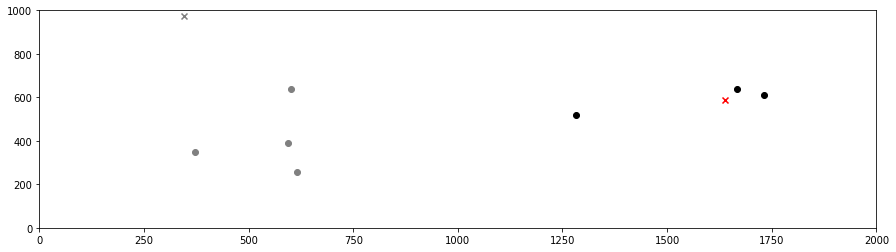

In [161]:
from scipy.spatial import distance
from scipy.stats import special_ortho_group

class ground_truth_factory(object):
    def __init__(self, params={}):
        self._bounds_ZYX = [100,1000,1000]
        self._center = [v/2.0 for v in self._bounds_ZYX]
        self._sample_bound_rad_ZYX = [25,250,250]
        #these are mu, sigma,d format for random transforms
        self._shift_params, self._noise_params = (0,10,3),(0,.5,3)
        self._min_sep = 20
        self._noise_factor = 1
        self._birth_rate = 0.5
        self._use_rotations = True#todo if using this check that we can a) invert it and b) vis and/or scale it to know what it does
        
    #i should also make that we pass in exisitng points and avoid those too
    #and also outliers should not be near anything else
    #because the online generation is less aggressive we may get away with it
    def generate(self, n, time_id=1, params = {}):
        def _near_any_(p,v):
            for p_ in v:
                if distance.euclidean(p,p_) <= self._min_sep:
                    return True
            return False
        
        def _exceeds_bounds_(pt): 
            if pt.min() <0:return True
            if np.min(np.array(self._bounds_ZYX) - pt) < 0: return True
            
        def _uniform_point_(low_bounds_zyx = [0,0,0], up_bounds_zyx=self._bounds_ZYX): 
            return np.array( [  np.random.uniform(low_bounds_zyx[i], up_bounds_zyx[i]) for i in range(3) ])
        
        bound_low = np.array(self._center) - np.array(self._sample_bound_rad_ZYX)
        bound_up = np.array(self._center) + np.array(self._sample_bound_rad_ZYX)
        
        inliers= []
        while len(inliers) < n:
            pt = _uniform_point_(bound_low,bound_up)
            if not _near_any_(pt,inliers) and not _exceeds_bounds_(pt):
                inliers.append(pt)
        
        outliers = [_uniform_point_() for i in range(self._noise_factor)]
        
        outliers = pd.DataFrame(outliers, columns=["z", "y", "x"])
        outliers["t"] = time_id
        outliers["t0"] = time_id
        outliers["type"] = 0
        outliers["end"] = None
        
        inliers = pd.DataFrame(inliers, columns=["z", "y", "x"])
        inliers["t"] = time_id
        inliers["t0"] = time_id
        inliers["type"] = 1
        inliers["end"] = np.random.binomial(7,p=0.6,size=len(inliers))
        
        return pd.concat([inliers,outliers])
    
    
#     import transforms3d as t3d
#     def random_transform(npa,max_t=0):
#         #the center of mass is used to translate to the origin
#         com = npa.mean()
#         #we take random small rotations on all axes
#         angles = [np.random.uniform(-np.pi/24,np.pi/24) for i in range(3)]
#         #translate to the origin
#         _npa = _translate_(npa, -1* com)
#         #get a random rotation marix and apply it
#         _npa = np.dot(npa, t3d.euler.euler2mat(*angles))
#         #triangle rule: random translation plus return from origin to where it was and add random translation
#         rvec = np.array([np.random.uniform(0,max_t) for i in range(3)]) + com
#         #return the translated tensor
#         return _translate_(_npa, rvec)

    def rotation_matrix(self):
        import transforms3d as t3d
        angles = [np.random.uniform(-np.pi/24,np.pi/24) for i in range(3)]
        return t3d.euler.euler2mat(*angles)
#         x1, x2, x3 = np.random.rand(3)
#         R = np.matrix([[np.cos(2 * np.pi * x1), np.sin(2 * np.pi * x1), 0],
#                        [-np.sin(2 * np.pi * x1), np.cos(2 * np.pi * x1), 0],
#                        [0, 0, 1]])
#         v = np.matrix([[np.cos(2 * np.pi * x2) * np.sqrt(x3)],
#                        [np.sin(2 * np.pi * x2) * np.sqrt(x3)],
#                        [np.sqrt(1 - x3)]])
#         H = np.eye(3) - 2 * v * v.T
#         M = -H * R
#         return M

    def __transform_factory__(self):
            def _t_(A):
                N = len(A)
                v=np.stack([np.random.normal(*self._shift_params)])
                Q = np.eye(v.shape[1]+1)
                Q[:v.shape[1],-1] = np.array(v)
                Q = np.matrix(Q)
                if self._use_rotations: Q[:3, :3] = special_ortho_group.rvs(3)
                #then need small noise to each to each point so it is not a precise translation
                noise= np.random.normal(*self._noise_params[:2],(N,3))
                #extend A dims
                _A = np.matrix(np.hstack((A,np.ones((len(A),1)))))
                _A = np.array(np.dot(_A, Q.T)) 
    
                return _A[:,:3] + noise     
            return _t_
    
    def transform(self, df, t_inc=1, params={}):
        """
        Transform a dataframe corrdinate set and maintain useful data in the dataframe returned for iterative use
        """
        #for joining we should keep a fixed ordinal
        df =df.reset_index().drop("index",1)
        cols = ["z", "y", "x"]
        hcols = ["z_d", "y_d", "x_d"]
        mat = df[cols]
        bound_check = np.array(self._bounds_ZYX)
        while True:
            _mat = self.__transform_factory__()(mat.values)
            if _mat.min() < 0 or (bound_check - _mat.max(axis=0)).min() < 0:continue
            #this is so that the transformed becomes the focus and the old cols are shifted (pattern is shift)
            df=df[[c for c in df.columns if c not in hcols]].rename(columns = dict(zip(cols,hcols)))
            df=df.join(pd.DataFrame(_mat, columns=cols))
            break

        #advance clock
        df["t"] = df["t"] + t_inc
        df=df[df.type>0] #not outliers
        df["type"] = 2 #advance type to 2 now that it is married
        
        #remove if they have reached their generated expiration date
        df = df[df.t < df.end]
        
        #the production count is a binomial variable - that could depend on population size but here is constant
        new_random = np.random.binomial(5,p=self._birth_rate,size=1)
        #add random new objects and outliers
        newdata = self.generate(new_random, time_id=df["t"].max())
        #add the default schema columns
        for c in hcols: newdata[c] = None
    
        #print("new data", newdata.columns)
        #print("existing data", df.columns)
        #return df[newdata.columns], newdata
        return pd.concat([df[newdata.columns], newdata])
    
    def plot(self,df,prev=None,draw_gt_marriages=True,tracker_marriages=None):
        markers = {0: "x", 1 : "o", 2:  "o" }
        colours = {0: "r", 1 : "k", 2: "b"}
        plt.figure(figsize=(15,4))
        offset = 0
        
        if prev is not None: 
            offset = self._bounds_ZYX[-1]
            
            for k, g in prev.groupby(["type"]):
                plt.scatter(g["x"],g["y"],c='grey', marker=markers[k])
                
            if draw_gt_marriages:
                for k,r in df.dropna().iterrows(): #risky - assume all fields normally filled
                    plt.plot([r["x"]+offset,r["x_d"]], [r["y"],r["y_d"]], 'k:')
                    
            if tracker_marriages is not None:
                for k,r in tracker_marriages[["z", "y", "x", "t", "z_d", "y_d", "x_d"]].dropna().iterrows():
                    plt.plot([r["x"]+offset,r["x_d"]], [r["y"],r["y_d"]], 'r:')

        for k, g in df.groupby(["type"]):#project to the delta (advanced time)
            plt.scatter(g["x"]+offset,g["y"],c=colours[k], marker=markers[k])
            
        plt.ylim(0,self._bounds_ZYX[1])
        plt.xlim(0,self._bounds_ZYX[-1]+offset)
        
    def evaluate_transform_against_ground_truth(self, t, obj, df,plot=True):
        """
        If the tracker proposes a transform and an objective, we can evalute directly here against the ground truth
        """
        pass
    
    def parameter_search(pset):
        pass
    
fac = ground_truth_factory()
data = fac.generate(10,1)

#run for however many iterations and we can write these somewhere too but update pr if we are going for more
all_data = []
for i in range(10):
    pr = data.copy()
    data = fac.transform(data)
    all_data.append(data.copy())
fac.plot(data,pr)
data

In [165]:
data = pd.concat(all_data)
data[:50]

,z,y,x,t,t0,type,end,z_d,y_d,x_d
0,43.972192,264.482305,289.425573,2.0,1.0,2,5,49.653946,319.495161,267.228289
1,24.997494,484.393304,430.046179,2.0,1.0,2,6,46.845730,561.219503,366.383529
2,70.875481,575.178792,780.607134,2.0,1.0,2,5,67.278767,705.237600,701.414284
3,97.407427,287.219746,655.103259,2.0,1.0,2,5,68.741387,399.117130,627.041291
4,54.548760,267.105918,457.669962,2.0,1.0,2,5,43.135901,350.304095,432.914102
7,14.485323,560.619766,628.080432,2.0,1.0,2,6,25.879945,671.508588,548.334837
8,54.206503,569.929870,632.195006,2.0,1.0,2,5,66.213849,676.790685,555.781183
9,40.318916,506.061524,666.414057,2.0,1.0,2,5,39.156973,622.023425,597.474078
0,28.547304,556.518910,298.633399,2.0,2.0,1,4,NaN,NaN,NaN
1,58.895570,380.281356,390.699986,2.0,2.0,1,1,NaN,NaN,NaN


In [148]:
#get access to the guys of the sampler and transformer and test for all parameters on frame-frame only

In [149]:
def make_test(pr,data):
    dc = set(data.columns)
    pc = set(pr.columns)
    for c in dc - pc:
        pr[c] = None
    pr = pr[data.columns]
    return pd.concat([pr,data])
test_data=make_test(pr,data)
test_data["t"] -= (test_data["t"].min() - 1)
test_data.to_csv("./samples/surrogate.csv")
test_data.head()

,z,y,x,t,t0,type,end,z_d,y_d,x_d
0,41.306652,394.767076,386.957350,1,1,2,4,41.901156,336.755944,431.649023
1,32.792030,342.116366,348.659853,1,1,2,4,32.119086,290.001204,385.490892
2,23.355169,439.954330,415.556143,1,1,2,4,27.266980,380.935977,462.099538
3,20.143028,623.607706,376.460122,1,1,2,5,59.689259,565.155599,447.303150
4,16.928334,519.123782,315.358924,1,1,2,4,50.152462,470.244887,371.870562


In [150]:
test_data.tail()

,z,y,x,t,t0,type,end,z_d,y_d,x_d
6,97.969783,385.027548,701.976685,2,1,2,4,26.522097,638.096670,508.314408
7,58.854317,331.470682,508.120369,2,1,2,4,37.583612,453.342954,420.754586
11,57.929104,469.985424,488.395719,2,2,2,4,41.585085,409.791642,553.776952
0,68.530640,327.113019,707.454667,2,3,1,4,NaN,NaN,NaN
0,3.484595,828.548907,809.862572,2,3,0,None,NaN,NaN,NaN


In [151]:
test_data = pd.read_csv("./samples/surrogate.csv").drop("Unnamed: 0",1)
T = 50
test_data.head()

,z,y,x,t,t0,type,end,z_d,y_d,x_d
0,41.306652,394.767076,386.957350,1,1,2,4.0,41.901156,336.755944,431.649023
1,32.792030,342.116366,348.659853,1,1,2,4.0,32.119086,290.001204,385.490892
2,23.355169,439.954330,415.556143,1,1,2,4.0,27.266980,380.935977,462.099538
3,20.143028,623.607706,376.460122,1,1,2,5.0,59.689259,565.155599,447.303150
4,16.928334,519.123782,315.358924,1,1,2,4.0,50.152462,470.244887,371.870562


In [156]:
from lightroot.tracking import tpctree
from lightroot import plots
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
%matplotlib inline
def error(test_data,merged_data):
    def _iseq_(row):
        for c in ["z_d", "y_d", "x_d"]:
            if row [c] - row[ c+"_tracker"] < 0.001:continue
            return 0
        return 1  
    chk = test_data.set_index(["z", "y", "x"]).join(merged_data.set_index(["z", "y", "x"]), rsuffix="_tracker")
    chk["eq"] = chk.apply(_iseq_,axis=1)
    #return chk
    return 1-chk["eq"].sum()/chk["eq"].count()

result = tpctree.process_file("./samples/surrogate.csv",start=0,end=T,
                              options={"transforms":True, 
                                       "epsilon":25, 
                                       "sample_size":1000,
                                       "use_tr_concensus": True,
                                       "debug": False,
                                       "lags" : [1]
                                      })

merged = []
for k, g in result.data.groupby("t"):
    if k == 1:continue
    df = g.set_index("key")
    merged.append(df.join(result.data[result.data["t"]==k-1],  how="outer", rsuffix="_d"))
merged=pd.concat(merged)




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]




('error', 0.0)

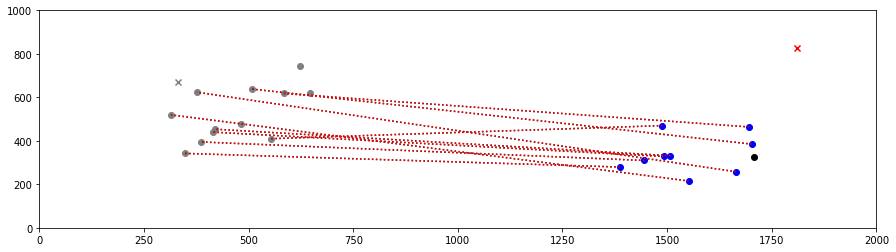

In [157]:
fac.plot(data,pr, draw_gt_marriages=True, tracker_marriages=merged)
my_test = round(test_data[(test_data.t==2) & (test_data.type == 2)],2).sort_values("z")
"error", error(my_test, round(merged,2))
#SHOULD NOT ACCEPT SOMETHING THAT JOINS TWICE TO THE SAME OBJECT

In [9]:
## Setup a simple scaffold to go through parameter space and measure the sucess on blues - create some plots - then get into the unit tested C version

In [10]:
#A GOOD START IS IF WE HIT ALL THE BLUES AND NONE OF THE BLACKS


In [11]:
#tempting to just hammer on but decompose the tracker into unit testable bits
#transformation/translation sampling
#objective minimisation
#alignment if ids
#all of this in C code

#I should late rupdate the rotation translations and stress test for translations, rotatrans, and high-order fluctuations

In [12]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from  matplotlib import colors

def plot_lines(npa, lines, ax,style='k-'):
    for k,v in lines.items():
        p1 = npa[k]
        for ptk in v:
            p2= npa[ptk]
            ax.plot(*zip(p1,p2),style)    
            
def plot(npa, lines = None, cols="k"):
    xs,ys,zs = npa[:,0],npa[:,1], npa[:,2]
    fig = plt.figure(figsize=(15,10))#figsize=(15,10)
    ax = fig.add_subplot(111, projection='3d')
    #style
    ax.xaxis.pane.fill, ax.yaxis.pane.fill,ax.zaxis.pane.fill = False,False,False
    ax.xaxis.pane.set_edgecolor('w'); ax.yaxis.pane.set_edgecolor('w'); ax.zaxis.pane.set_edgecolor('w')
    #
    ax.set_ylim(-40,40)
    ax.set_xlim(-40,40)
    ax.set_zlim(-40,40)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    cmap = colors.ListedColormap(['lightgrey', 'red'])
    boundaries = [-1,1]
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    
    graph = ax.scatter(xs, ys, zs, c=cols, marker='o', cmap='Reds', s=40)
    if lines is not None: plot_lines(npa,lines,ax)
    return fig, graph, ax
    
    
def _translate_(npa, vec):
    Tr = np.eye(4)
    Tr[:3,-1] = vec
    padder = lambda A :  np.matrix(np.hstack((A,np.ones((len(A),1)))))
    return np.array(np.dot(padder(npa),Tr.T)[:,:-1])

In [13]:
import transforms3d as t3d
def random_transform(npa,max_t=0):
    #the center of mass is used to translate to the origin
    com = npa.mean()
    #we take random small rotations on all axes
    angles = [np.random.uniform(-np.pi/24,np.pi/24) for i in range(3)]
    #translate to the origin
    _npa = _translate_(npa, -1* com)
    #get a random rotation marix and apply it
    _npa = np.dot(npa, t3d.euler.euler2mat(*angles))
    #triangle rule: random translation plus return from origin to where it was and add random translation
    rvec = np.array([np.random.uniform(0,max_t) for i in range(3)]) + com
    #return the translated tensor
    return _translate_(_npa, rvec)

def interpolate_points_origin(pts,lines):
        for k,v in lines.items():
            p1 = npa[k]
            for ptk in v:
                p2= npa[ptk]
                #because we are using the origin cube and lines only one axis can satisfy below
                axis_to_intrp = np.argmax(np.abs(np.array(p1) - np.array(p2)))
                vals = np.linspace(p2[axis_to_intrp],p1[axis_to_intrp],10)
                for v in vals:
                    p = list(p1)
                    p[axis_to_intrp] = v
                    yield p

In [23]:
#3d square
%matplotlib notebook
cube = [[10,-10,-10],[10,-10,10],
        [10,10,-10],[10,10,10],
        [-10,10,-10],[-10,10,10],
        [-10,-10,-10],[-10,-10,10]        
     ]
#interpolated points - between each pair, name an axis i.e. 0,1,2 and we need twele pairs - each point joins 3 other points
lines = { 0: [1, 2, 6], 1: [0,3,7], 2: [0,3,4], 3: [1,2,5], 4: [2,5,6], 5: [3,4,7], 6: [0,4,7] }
npa = np.array(cube)
print("com", npa.mean(axis=0))
npa=np.array(list(interpolate_points_origin(npa, lines)))

com [0. 0. 0.]


(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x249ab63e198>)

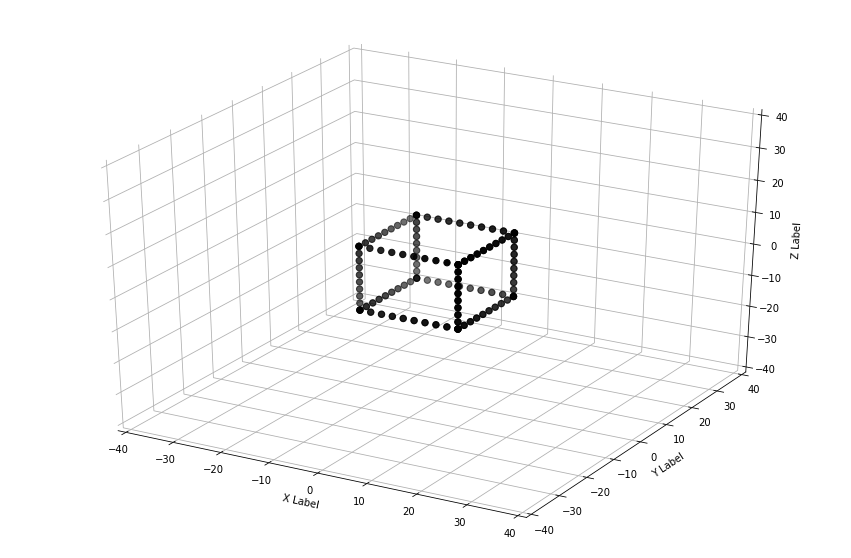

In [24]:
%matplotlib inline
cols = [0 if v == 0 else 1 for v in np.random.binomial(1,0.1,len(npa))]
plot(npa,cols="k")

In [25]:
#plot(random_transform(npa, max_t=5),)

In [26]:
# cols = ["lightgrey" if v == 0 else "r" for v in np.random.binomial(1,0.1,len(npa))]
# cols = ["white" if v == 0 else "r" for v in np.random.binomial(1,0.1,len(npa))]
# plot(random_transform(npa, max_t=5),cols=cols)

In [27]:
#simulate life matrix: uniform spread of now objects biasing lots at beginning and lifetimes approx 3 frames
N = 500
T = 100
births = np.random.randint(-5, T, N)
lifes = pd.DataFrame(np.column_stack([births,np.random.binomial(7,p=0.6,size=len(births))]),columns=["birth_time", "life_time"])
lifes.loc[lifes.birth_time<0,"birth_time"] = 0
#lifes=lifes.sort_values("birth_time") # <- this is just to vis but actually we want to assign randomly to cube cells
lifes.head()

,birth_time,life_time
0,24,3
1,16,4
2,76,3
3,94,6
4,16,4


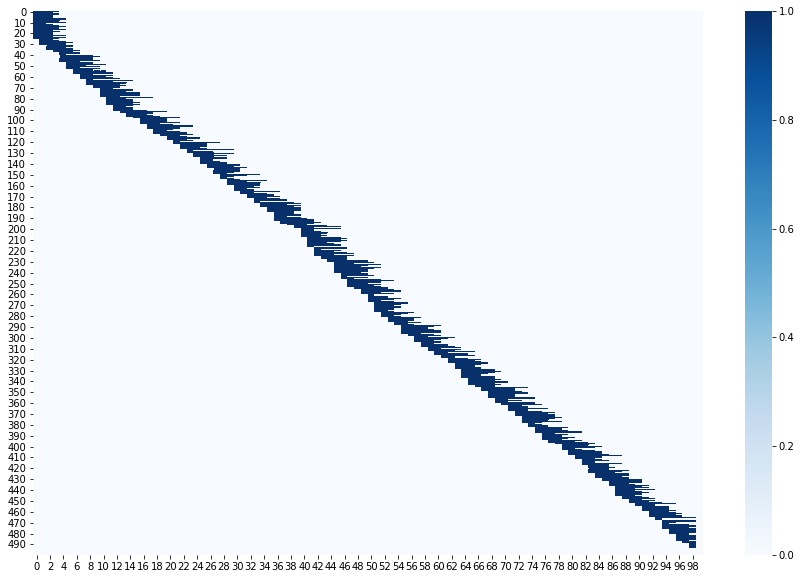

In [28]:
#make life matrix
def life_matrix_rows(lifes):
    capped = lambda x : x if x < T else T -1
    for k, r in lifes.iterrows():
        mask = np.zeros(T,np.int)
        mask[r["birth_time"]:capped(r["birth_time"]+r["life_time"])] = 1
        yield mask

life_matrix = pd.DataFrame(life_matrix_rows(lifes.sort_values("birth_time")))
lm = np.stack(life_matrix_rows(lifes))
import seaborn as sns
plt.figure(figsize=(15,10))
sns.heatmap(life_matrix,cmap="Blues")

## Animaton

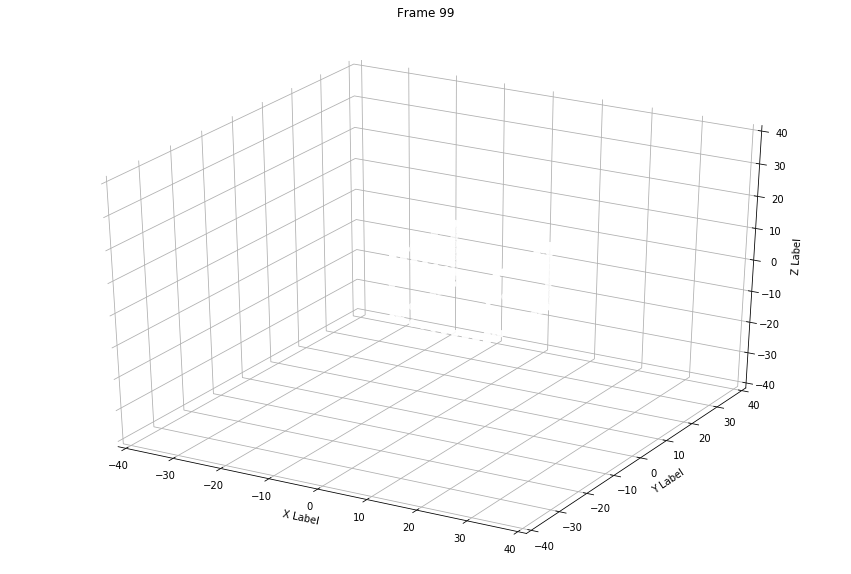

In [31]:
from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import to_rgba_array


JUST_BLACK = False

cols = [0 if v == 0 else 1 for v in np.random.binomial(1,0.1,len(npa))]
fig, g, ax = plot(npa, cols=cols) if not JUST_BLACK else plot(npa)

all_data = [npa.copy()]

def updatefig(t=0,npa=npa):
    npa = random_transform(npa, max_t=5)
    all_data.append(npa.copy())
    g._offsets3d = ( np.ma.ravel(npa[:,0]) , np.ma.ravel(npa[:,1]) , np.ma.ravel(npa[:,2]) )

    if not JUST_BLACK:
        g._facecolor3d = to_rgba_array("white")
        g._edgecolor3d = to_rgba_array("white")
        g.set_array(lm[:,t%T])  
        ax.set_title("Frame {}".format(t%T))
    
    return g,

ani = animation.FuncAnimation(fig, updatefig, frames=T, interval=200, blit=True)
ok = HTML(ani.to_html5_video())
res = ani.save('cube.mp4', fps=1)

In [32]:
ok

In [70]:
dfs = []
for i, a in enumerate(all_data):
    df = pd.DataFrame(a)
    df["t"] = i
    dfs.append(df)
df = pd.concat(dfs)
df.columns = ["x", "y", "z", "t"]
df.head()

,x,y,z,t
0,10.0,-10.0,10.000000,0
1,10.0,-10.0,7.777778,0
2,10.0,-10.0,5.555556,0
3,10.0,-10.0,3.333333,0
4,10.0,-10.0,1.111111,0


In [71]:

df[["x", "y", "z"]] += 100

df[["x", "y", "z"]] *= 5
#save this as surrogate and run the tracker - do we use epsilon 1 or do we scale the data first?
#make a function surrogate.cube(epsilon, noise) # can I tune it to just have the right number distribution per time e.g. 8 with sdev 5 or whatever for now
#MIGHT NEED SOME NOISE in the particle wobble
#so run the tracker over T frames for each of the parameters in epsilon and noise - ill probably just choose q of each and leave it run 


In [72]:
df.to_csv("./samples/surrogate.csv")

In [77]:
df.head()

,x,y,z,t
0,550.0,450.0,550.000000,0
1,550.0,450.0,538.888889,0
2,550.0,450.0,527.777778,0
3,550.0,450.0,516.666667,0
4,550.0,450.0,505.555556,0
